# Forecasting Weekly Data with Prophet

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Generate Data 

We generate a time series by including the following components:

- We include a non-linear **trend** of the form $\text{trend}(\tau) = (\tau + 1)^{2/5} + \log(\tau + 3)$.

- Seasonality:

    - We use the formula $\sin(2\pi \times \text{day_of_month}/\text{daysinmonth})$ to generate a **monthly seasonality**.  
    - We use the formula $\sin(2\pi \times\text{month}/3) + \cos(2\pi \times \text{month}/4)$ to generate the **yearly  seasonality**. Note that as $3$ and $4$ are relative primes, which implies that the period is the least common multiple $\text{lcm}(3, 4)=12$. 
    - We model the **End of the year season** as a [bump function](https://juanitorduz.github.io/bump_func/). 

- Gaussian Noise

In [2]:
np.random.seed(seed=42)

def generate_time_series_df(start_date, end_date, freq):
    """Generate time series sample data."""
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq)

    df = pd.DataFrame(data={'ds': date_range})
    
    # Get date variables. 
    df['day_of_month'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['daysinmonth'] = df['ds'].dt.daysinmonth
    df['week'] = df['ds'].dt.week
    
    # Time Series Components 
    ## Trend
    df['trend'] = np.power(df.index.values + 1, 2/5) + np.log(df.index.values + 3)
    ## Seasonal
    df['monthly_seas'] = np.cos(2*np.pi*df['day_of_month']/df['daysinmonth'])
    df['yearly_seas'] = 1.2*(np.sin(np.pi*df['month']/3) + np.cos(2*np.pi*df['month']/4))
    df['end_of_year']= - 8.5*np.exp(- ((df['week'] - 51.5)/1.0)**2) \
    ## Gaussian noise
    df['noise'] = np.random.normal(loc=0.0, scale=0.3, size=df.shape[0])
    
    # Target variable.
    df['y'] = df['trend'] \
        + df['monthly_seas'] \
        + df['yearly_seas'] \
        + df['end_of_year'] \
        + df['noise']
    
    return df

df = generate_time_series_df(
    start_date='2016-06-30', 
    end_date='2020-10-31', 
    freq='W'
)

df.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,ds,day_of_month,month,daysinmonth,week,trend,monthly_seas,yearly_seas,end_of_year,noise,y
0,2016-07-03,3,7,31,26,2.098612,0.820763,1.03923,-3.384013e-282,0.149014,4.107620
1,2016-07-10,10,7,31,27,2.705802,-0.440394,1.03923,-1.754511e-260,-0.041479,3.263159
2,2016-07-17,17,7,31,28,3.161283,-0.954139,1.03923,-1.231094e-239,0.194307,3.440681
3,2016-07-24,24,7,31,29,3.532861,0.151428,1.03923,-1.169062e-219,0.456909,5.180428
4,2016-07-31,31,7,31,30,3.849564,1.000000,1.03923,-1.502431e-200,-0.070246,5.818549


Let us plot the resulting time series:

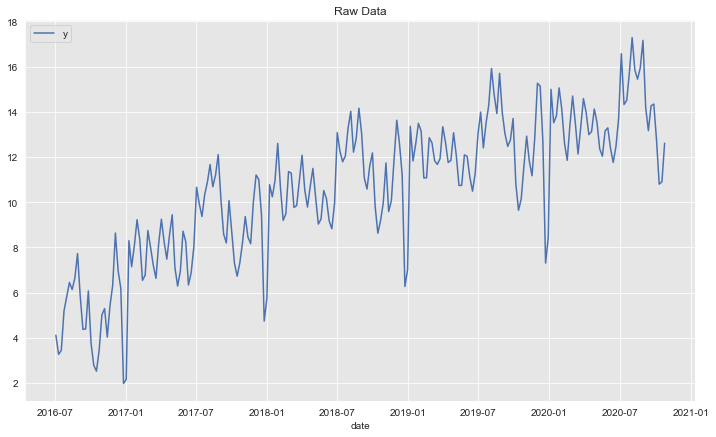

In [3]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y', data=df, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Raw Data', xlabel='date', ylabel='');

Let us now plot the individual components:

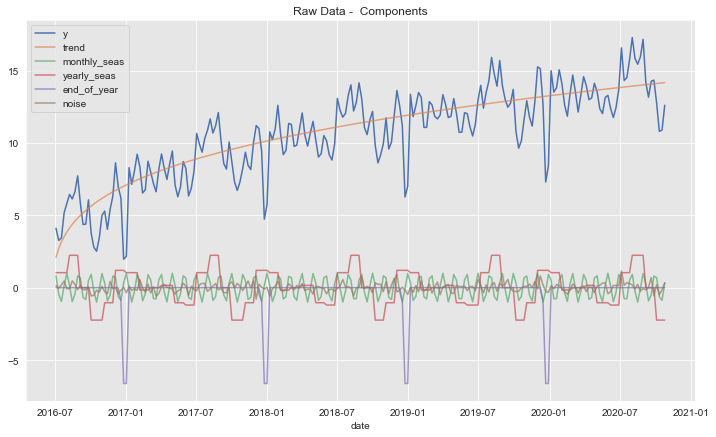

In [4]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y', data=df, ax=ax)
sns.lineplot(x='ds', y='trend', label='trend', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='monthly_seas', label='monthly_seas', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='yearly_seas', label='yearly_seas', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='end_of_year', label='end_of_year', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='noise', label='noise', data=df, alpha=0.7, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Raw Data -  Components', xlabel='date', ylabel='');

## Training - Test Split

Let us split the data into a training and test set in order to evaluate our model.

In [5]:
# Define threshold date.
threshold_date = pd.to_datetime('2019-11-01')
mask = df['ds'] < threshold_date
# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y']]
df_test = df[~ mask][['ds', 'y']]

**Warning:** *The input to Prophet is always a dataframe with two columns: `ds` and `y`*^[[Prophet Docs - Quick Start](https://facebook.github.io/prophet/docs/quick_start.html)]

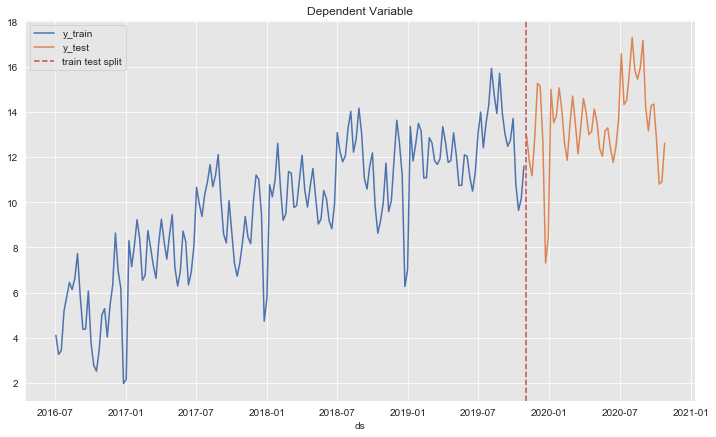

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

## Define Model

Now we define the forecasting model structure. 

### Holidays: End of the Year

In most of the resources available, Prophet is applyed to daily data. Here we are interested in the specefic case of weekly data. The generalization is pretty straight forward. Nevertheless, There are some important aspects one needs to be particularly careful about. 

According to the documentation^[[Prophet Docs - Modeling Holidays and Special Events](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events)] we can model specific special envents by explicitly including them into a `holidays` data frame which mucst have at least two columns `ds`: date stamp and `holiday`: name of the event. In addition, we can include two columns `lower_window` and `upper_window` which extend the event time stamp to the interval [`ds` - `lower_window`, `ds` + `upper_window`] ini days. 

**Warning:** The `holidays` data frame must contain the events in the historical data and also in the future.

To create this data frame for our concrete use case let us get the week date stamps for the end of the year season. 

In [7]:
# End of the year season.
mask_eoy = (df['month']==12) & (df['day_of_month'] > 21)

df[mask_eoy][['ds', 'end_of_year', 'y']]

,ds,end_of_year,y
25,2016-12-25,-6.619807,1.974179
77,2017-12-24,-6.619807,4.736599
78,2017-12-31,-6.619807,5.744007
129,2018-12-23,-6.619807,6.269033
130,2018-12-30,-6.619807,7.014116
181,2019-12-22,-6.619807,7.304637
182,2019-12-29,-6.619807,8.433138


We use these dates to create the `holidays` data frame.

In [8]:
def create_end_of_year_holydays_df():
    """Create holydays data frame for the end of the year season."""
    holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2016-12-25', '2017-12-24', '2018-12-23', '2019-12-22']
      ),
      'lower_window': -7,
      'upper_window': 7,
    })
    return holidays

**Warning:** In a first implementation I just used the 24th of December as the event date stamp. This however did not produce the right result as in the `forecast` below, the `end_of_year` indication function did not appear in the future window. You can see the thread in the [pull request](https://github.com/juanitorduz/website_projects/pull/13) associated to this notebook. This is definitely something to be aware of when working with weekly data in Prophet. 

## Build Model

Now we define the forecasting model object.

In [9]:
def build_model():
    """Define forecasting model."""
    # Create holidays data frame. 
    holidays = create_end_of_year_holydays_df()
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        holidays = holidays, 
        interval_width=0.95, 
        mcmc_samples = 500
    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )
    
    return model
    
model = build_model()

**Remarks:**

   - We specify to fit the `yearly_seasonality` with the *auto* option for the Fourier modes.
   - We ask for the 0.95 `interval_with` instead of the default (0.8).
   - We include the `mcmc_samples` option to get uncertainty in seasonality (via Bayesian sampling).
   - We add monthly seasonality by specifying the `period` and `fourier_order`. This is the general strategy for adding any type of seasonality^[[Prophet Docs - Specifying Custom Seasonalities](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities)]. 

In [10]:
# We train the model with the training data. 
model.fit(df_train)

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



## Generate Predictions

Let us get the model predictions. First we extend the dates from the traiining data. 

In [11]:
# Extend dates and features. 
future = model.make_future_dataframe(periods=df_test.shape[0], freq='W')
# Generate predictions. 
forecast = model.predict(df=future)

Let us see the columns of the `forecast` data frame.

In [12]:
for c in forecast.columns.sort_values():
    print(c)

additive_terms
additive_terms_lower
additive_terms_upper
ds
end_of_year
end_of_year_lower
end_of_year_upper
holidays
holidays_lower
holidays_upper
monthly
monthly_lower
monthly_upper
multiplicative_terms
multiplicative_terms_lower
multiplicative_terms_upper
trend
trend_lower
trend_upper
yearly
yearly_lower
yearly_upper
yhat
yhat_lower
yhat_upper


- The variable `yhat` represents the model predictions.
- For all the components we have the `_lower` and `_upper` bounds.

Let us verify the encoding of the `end_of_year` season in the `forecast` data frame.

In [13]:
forecast[forecast['end_of_year'].abs()>0][['ds', 'end_of_year']]

,ds,end_of_year
24,2016-12-18,-1.777649
25,2016-12-25,-7.409719
26,2017-01-01,-6.890639
76,2017-12-17,-1.777649
77,2017-12-24,-7.409719
78,2017-12-31,-6.890639
128,2018-12-16,-1.777649
129,2018-12-23,-7.409719
130,2018-12-30,-6.890639
180,2019-12-15,-1.777649


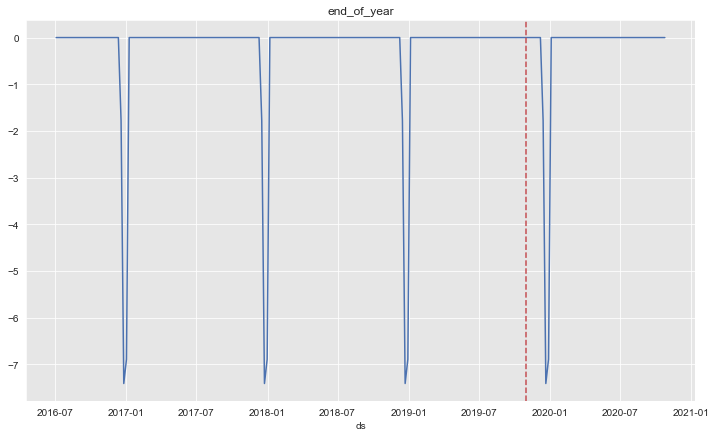

In [14]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='end_of_year', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.set(title='end_of_year', ylabel='');

The seasonality works as expected (see **Warning** above).

Let us split the predictions into trainiing and test set. 

In [15]:
mask2 = forecast['ds'] < threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

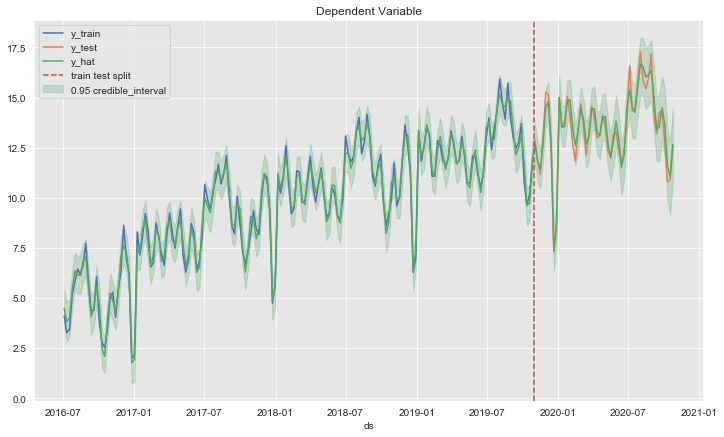

In [16]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

Zooming in:

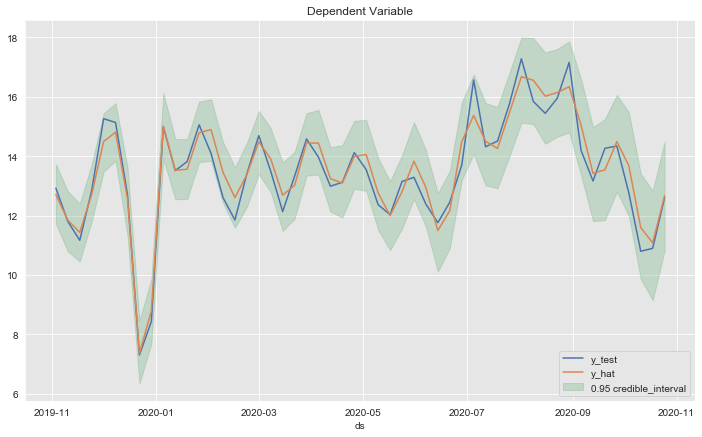

In [17]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

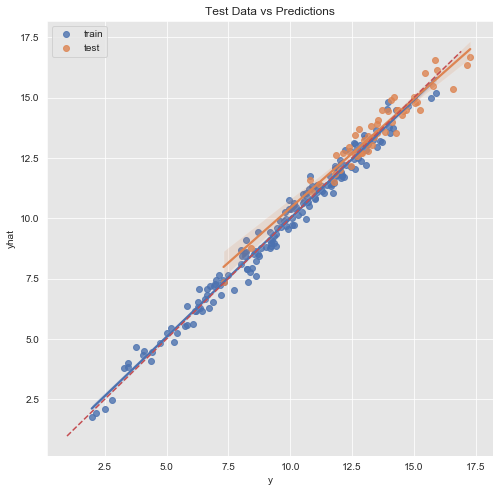

In [18]:
fig, ax = plt.subplots(figsize=(8,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

Let us compute the `r2_score` and `mean_absolute_error` on the training and test set respectively: 

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))

r2 train: 0.9830400819483691
r2 test: 0.9314491608694568
------------------------------
mae train: 0.31208824356951176
mae test: 0.3900594757772865


This might indicate a potential overfit. In a second iteration one could modify the `prior_scale` in the model definition to add more regularization^[[Prophet Docs - Prior Scale for Holidays and Seasonality](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#prior-scale-for-holidays-and-seasonality)].

## Error Analysis

Let us study the forecast errors. 

- Distribution

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



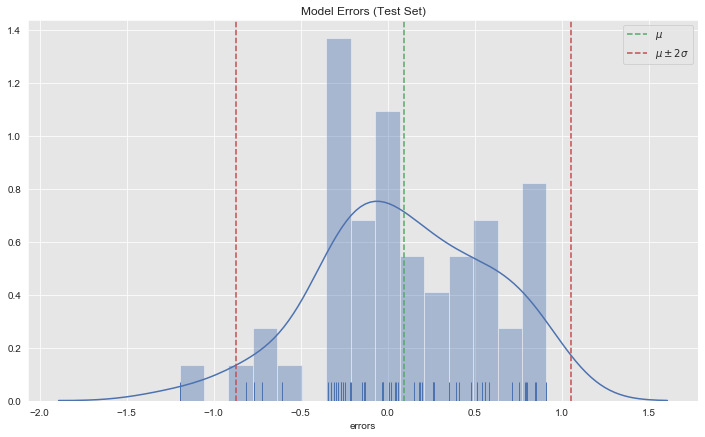

In [20]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots()

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

- Autocorrelation 

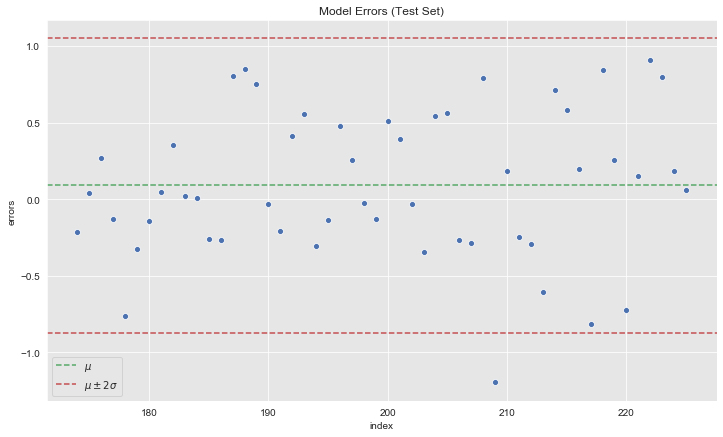

In [21]:
fig, ax = plt.subplots()

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

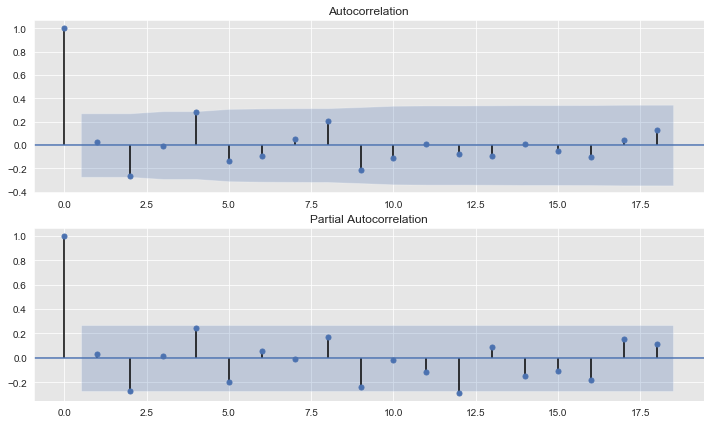

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1)
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

## Model Deep Dive

- Model Components

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



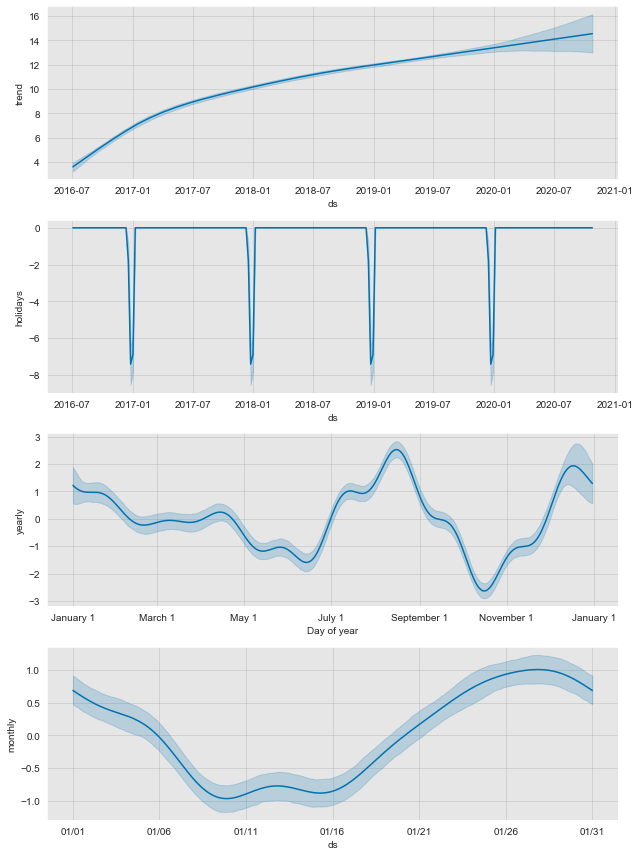

In [23]:
# Plot model components.
fig = model.plot_components(forecast)

- Trend Fit 

Let us plot where 

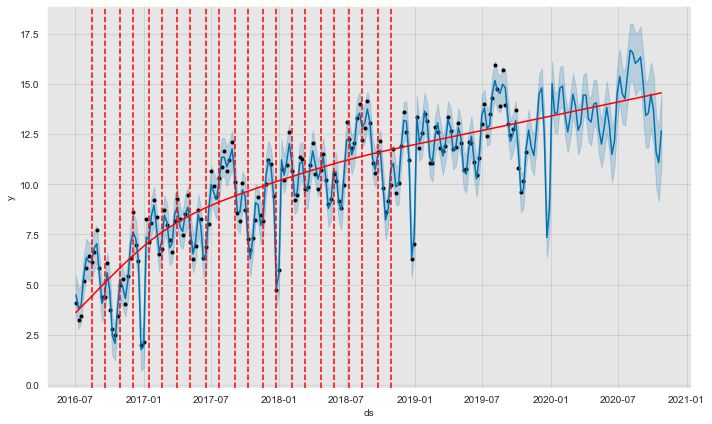

In [24]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

Let us compare the true and the fitted trend:

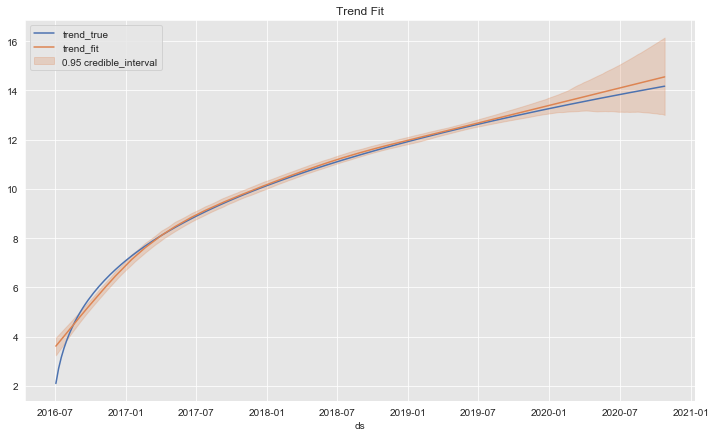

In [25]:
fig, ax = plt.subplots()

sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');